In [7]:
# =========================
# 1. Import librerie
# =========================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans
from tslearn.metrics import cdist_dtw
from tslearn.clustering import TimeSeriesKMeans

In [8]:
import pandas as pd
from sktime.datasets import load_gunpoint
from sktime.clustering.k_means import TimeSeriesKMeans
import seaborn as sns
from sktime.utils.plotting import plot_series
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [9]:
df = pd.read_csv("/Users/chiaraferrara/Desktop/Unipi/Magistrale/DM 2/dm2_project/dm2_dataset_2425_imdb/imdb_ts.csv")  

In [56]:
import numpy as np
import pandas as pd
import stumpy
from tslearn.clustering import TimeSeriesKMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Parametri
ts_cols = [str(i) for i in range(100)]
window_size = 28     # per i motifs
top_k = 1           # take top 3 motif indices
#n_clusters = 5      # numero di cluster
random_state = 42

# Normalizzazione Z-score
X = df[ts_cols].values.astype(float)
Xz = (X - X.mean(axis=1, keepdims=True)) / X.std(axis=1, keepdims=True)

# Collezione motifs
motifs = []
ids = []
for idx, ts in enumerate(Xz):
    mp = stumpy.stump(ts, window_size)
    prof = mp[:, 0]
    nn_idx = mp[:, 1].astype(int)
    # Prendi primi top_k motifs (minimi)
    motif_idxs = np.argsort(prof)[:top_k]
    for mi in motif_idxs:
        motifs.append(ts[mi:mi + window_size])
        ids.append(df.iloc[idx]['id'])

# DataFrame dei motifs
motif_df = pd.DataFrame({
    'film_id': ids,
    'motif': motifs
})


# Converti motifs in array 2D
motif_array = np.vstack(motif_df['motif'].values)


#motif_array = np.array([(m - m.mean()) / m.std() for m in motifs])





# # Clustering
# motif_array = np.stack(motifs)
# model = TimeSeriesKMeans(n_clusters=n_clusters, metric="dtw", random_state=random_state)
# labels = model.fit_predict(motif_array)

# motif_df['cluster'] = labels

# # Visualizza cluster centroids
# fig, axes = plt.subplots(n_clusters, 1, figsize=(8, 2*n_clusters), sharex=True)
# for c in range(n_clusters):
#     axes[c].plot(model.cluster_centers_[c].ravel(), label=f'Cluster {c}')
#     axes[c].legend()
# plt.show()


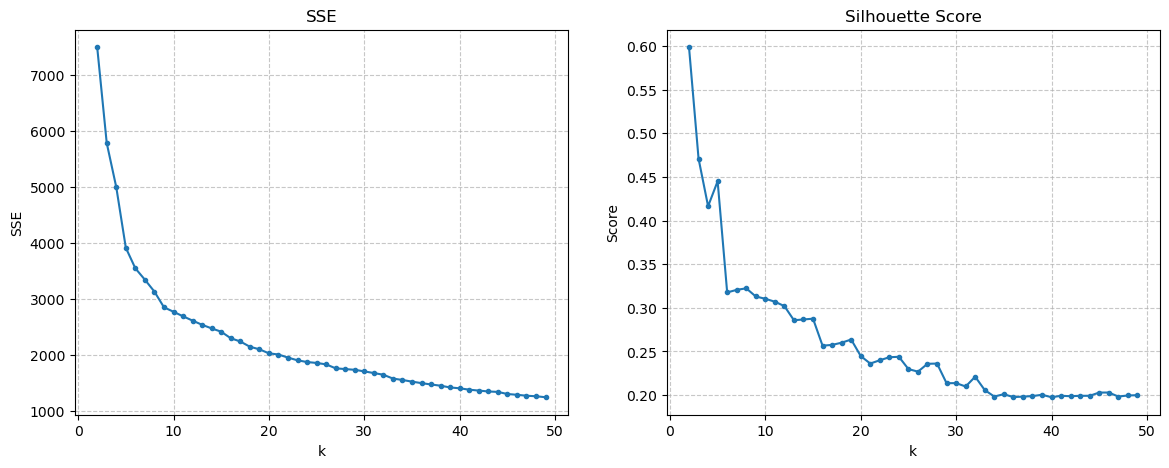

In [57]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

inertia_vals = []
silhouette_vals = []
K = range(2, 50)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(motif_array)
    inertia_vals.append(kmeans.inertia_)
    silhouette_vals.append(silhouette_score(motif_array, labels))

plt.figure(figsize=(14, 5))
plt.subplot(1,2,1)
plt.plot(K, inertia_vals, 'o-', markersize=3)
plt.title("SSE")
plt.xlabel("k"); plt.ylabel("SSE")
plt.grid(linestyle="--", alpha=0.7)

plt.subplot(1,2,2)
plt.plot(K, silhouette_vals, 'o-', markersize=3)
plt.title("Silhouette Score")
plt.xlabel("k"); plt.ylabel("Score")
plt.grid(linestyle="--", alpha=0.7)
plt.show()


In [75]:
n_clusters = 5  # scelto in base ai grafici precedenti

In [76]:
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
labels = kmeans.fit_predict(motif_array)

# Aggiungi i cluster al DataFrame
motif_df['cluster'] = labels

# Centroidi (pattern medi dei cluster)
centroids = kmeans.cluster_centers_


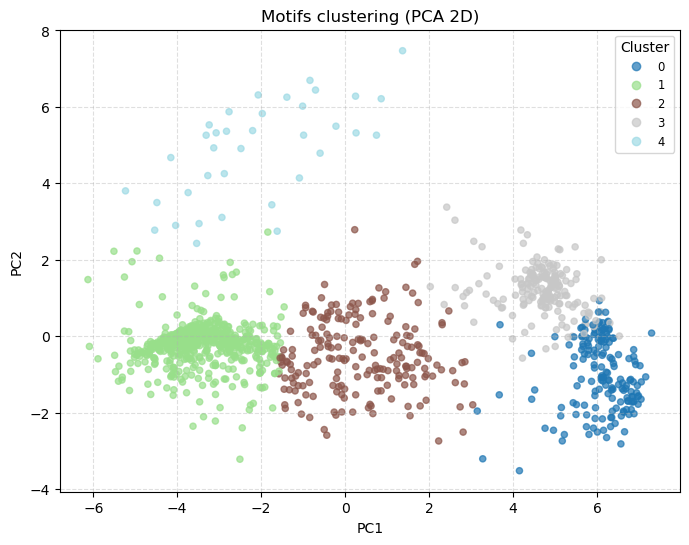

In [77]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

# PCA a 2 dimensioni
pca = PCA(n_components=2)
motif_2d = pca.fit_transform(motif_array)

# Scatter plot
plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    motif_2d[:, 0], 
    motif_2d[:, 1], 
    c=labels, 
    cmap='tab20', 
    s=20, 
    alpha=0.7
)

# Legenda con identificativo cluster
plt.legend(*scatter.legend_elements(), title="Cluster", loc="best", fontsize='small')
plt.title("Motifs clustering (PCA 2D)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(alpha=0.4, linestyle='--')
plt.show()


In [78]:
# Aggiungi rating_category unendo con df originale
motif_df = motif_df.merge(df[['id', 'rating_category']], left_on='film_id', right_on='id', how='left')
motif_df.drop(columns=['id'], inplace=True)

In [79]:
# Ora puoi fare la distribuzione
motif_counts = motif_df.groupby(['rating_category', 'cluster']).size().unstack(fill_value=0)
print(motif_counts)

cluster           0    1   2   3   4
rating_category                     
High             53  153  95  48  28
Low               1    8   0   1   0
Medium           67  199  53  67   1
Medium High      37  106  41  41   7
Medium Low       11   82  11  24   0


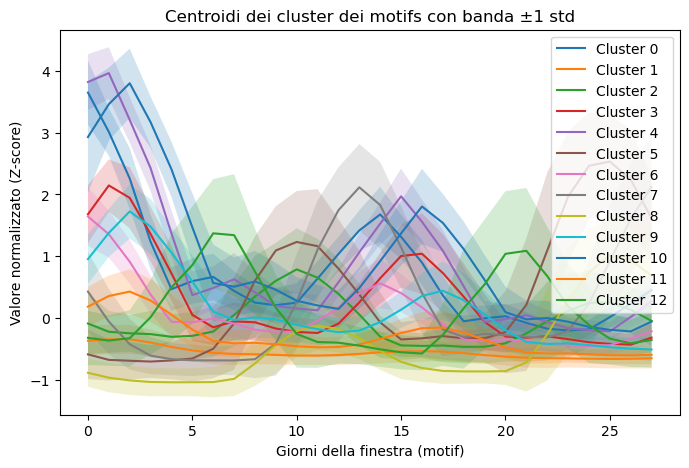

In [49]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(8, 5))

for i in range(n_clusters):
    centroid = kmeans.cluster_centers_[i]
    # Calcolo della deviazione standard dei motifs appartenenti al cluster
    cluster_motifs = motif_array[labels == i]
    std_dev = cluster_motifs.std(axis=0)
    
    plt.plot(centroid, label=f'Cluster {i}')
    plt.fill_between(
        np.arange(len(centroid)),
        centroid - std_dev,
        centroid + std_dev,
        alpha=0.2
    )

plt.title("Centroidi dei cluster dei motifs con banda ±1 std")
plt.xlabel("Giorni della finestra (motif)")
plt.ylabel("Valore normalizzato (Z-score)")
plt.legend()
plt.show()


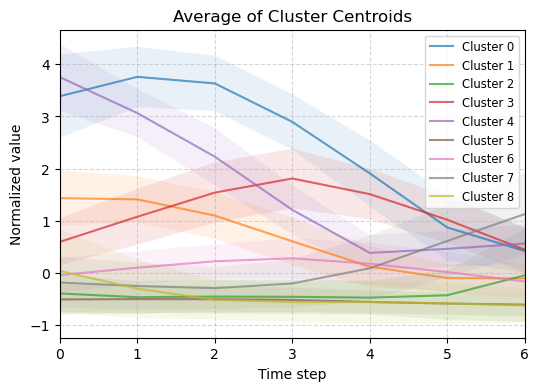

In [44]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(6, 4))

for i in range(n_clusters):
    centroid = kmeans.cluster_centers_[i]
    cluster_motifs = motif_array[labels == i]
    std_dev = cluster_motifs.std(axis=0)
    
    plt.plot(centroid, label=f'Cluster {i}', alpha=0.7)
    plt.fill_between(
        np.arange(len(centroid)),
        centroid - std_dev,
        centroid + std_dev,
        alpha=0.1
    )

plt.title("Average of Cluster Centroids")
plt.xlabel("Time step")
plt.ylabel("Normalized value")
plt.legend( loc='upper right', fontsize='small')
plt.xlim(0, 6)
plt.grid(alpha=0.5, linestyle='--')
plt.show()


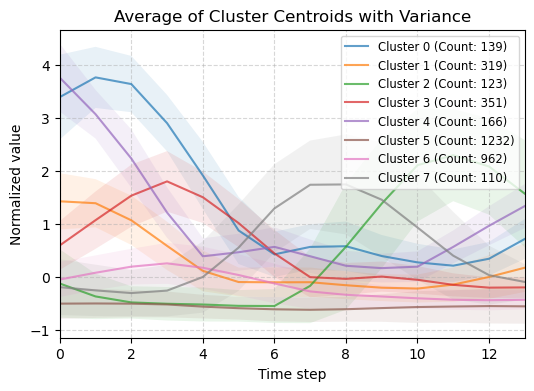

In [32]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Calcolo dei counts dei motifs per cluster
cluster_counts = pd.Series(labels).value_counts().sort_index()

plt.figure(figsize=(6, 4))

for i in range(n_clusters):
    centroid = kmeans.cluster_centers_[i]
    cluster_motifs = motif_array[labels == i]
    std_dev = cluster_motifs.std(axis=0)
    
    plt.plot(centroid, label=f'Cluster {i} (Count: {cluster_counts[i]})', alpha=0.7)
    plt.fill_between(
        np.arange(len(centroid)),
        centroid - std_dev,
        centroid + std_dev,
        alpha=0.1
    )

plt.title("Average of Cluster Centroids with Variance")
plt.xlabel("Time step")
plt.ylabel("Normalized value")
plt.legend(loc='upper right', fontsize='small')
plt.xlim(0, window_size-1)
plt.grid(alpha=0.5, linestyle='--')
plt.show()


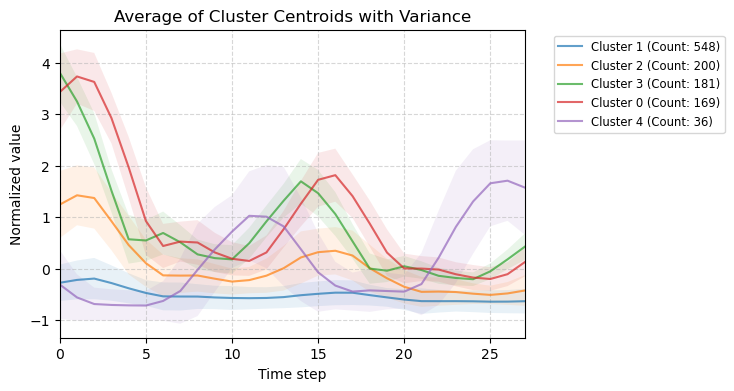

In [80]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Calcolo dei counts dei motifs per cluster
cluster_counts = pd.Series(labels).value_counts().sort_index()

plt.figure(figsize=(6, 4))

# Ordine dei cluster in base al numero di motifs (decrescente)
sorted_clusters = cluster_counts.sort_values(ascending=False).index

legend_labels = []

for i in sorted_clusters:
    centroid = kmeans.cluster_centers_[i]
    cluster_motifs = motif_array[labels == i]
    std_dev = cluster_motifs.std(axis=0)

    plt.plot(centroid, label=f'Cluster {i} (Count: {cluster_counts[i]})', alpha=0.7)
    plt.fill_between(
        np.arange(len(centroid)),
        centroid - std_dev,
        centroid + std_dev,
        alpha=0.1
    )

plt.title("Average of Cluster Centroids with Variance")
plt.xlabel("Time step")
plt.ylabel("Normalized value")
plt.legend(
    bbox_to_anchor=(1.05, 1),
    loc='upper left',
    fontsize='small'
)

plt.xlim(0, window_size - 1)
plt.grid(alpha=0.5, linestyle='--')
plt.show()


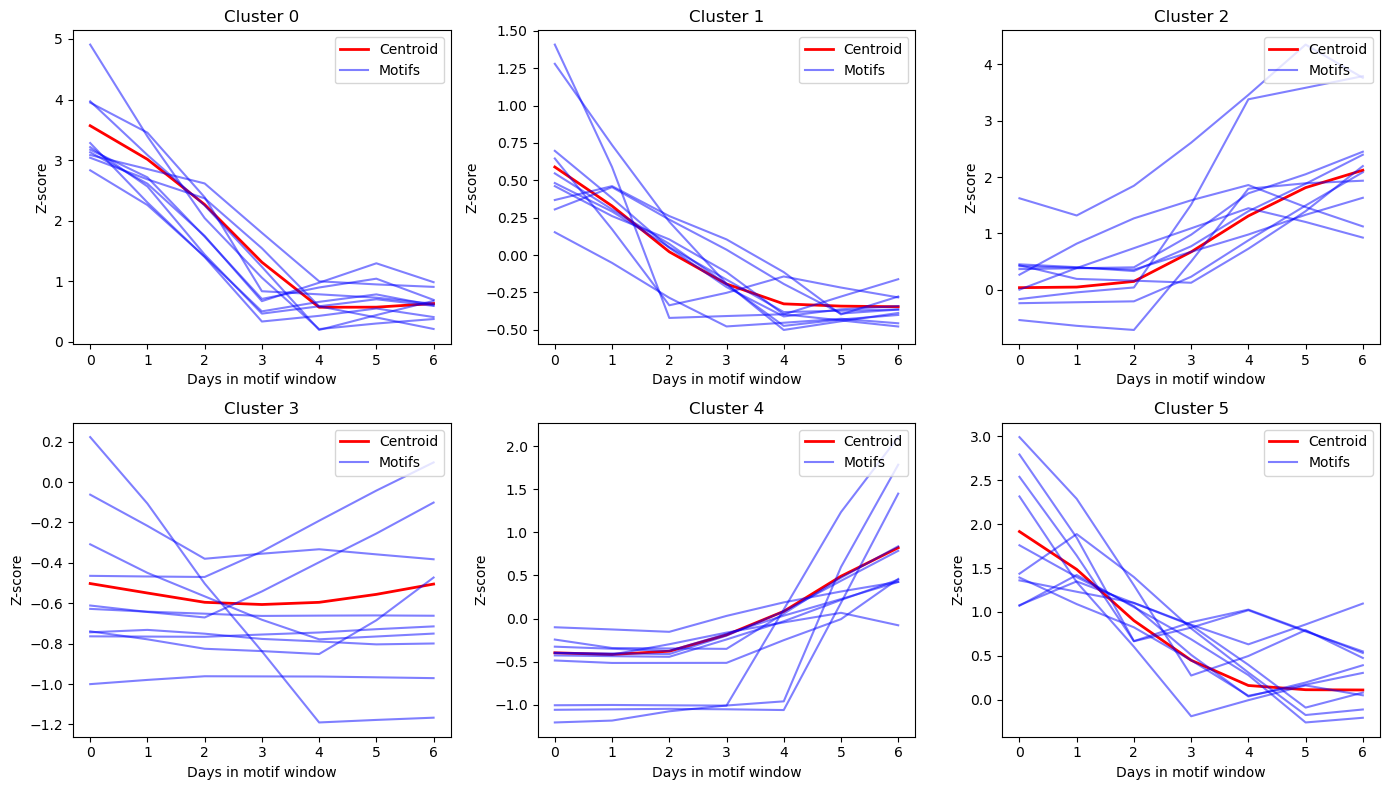

In [12]:
import random

# Numero di motifs da mostrare per cluster
n_examples = 10

plt.figure(figsize=(14, 8))

for i in range(n_clusters):
    plt.subplot(2, 3, i+1)  # 2 righe x 3 colonne, adatta se n_clusters = 6
    # Centroid
    plt.plot(kmeans.cluster_centers_[i].ravel(), label='Centroid', color='red', linewidth=2)
    
    # Seleziona n_examples motifs casuali del cluster i
    cluster_motifs = motif_df[motif_df['cluster'] == i]['motif'].tolist()
    if len(cluster_motifs) > n_examples:
        sample_motifs = random.sample(cluster_motifs, n_examples)
    else:
        sample_motifs = cluster_motifs
    
    # Plot motifs
    for motif in sample_motifs:
        plt.plot(motif, color='blue', alpha=0.5)
    
    plt.title(f'Cluster {i}')
    plt.xlabel('Days in motif window')
    plt.ylabel('Z-score')
    plt.legend(['Centroid', 'Motifs'], loc='upper right')

plt.tight_layout()
plt.show()


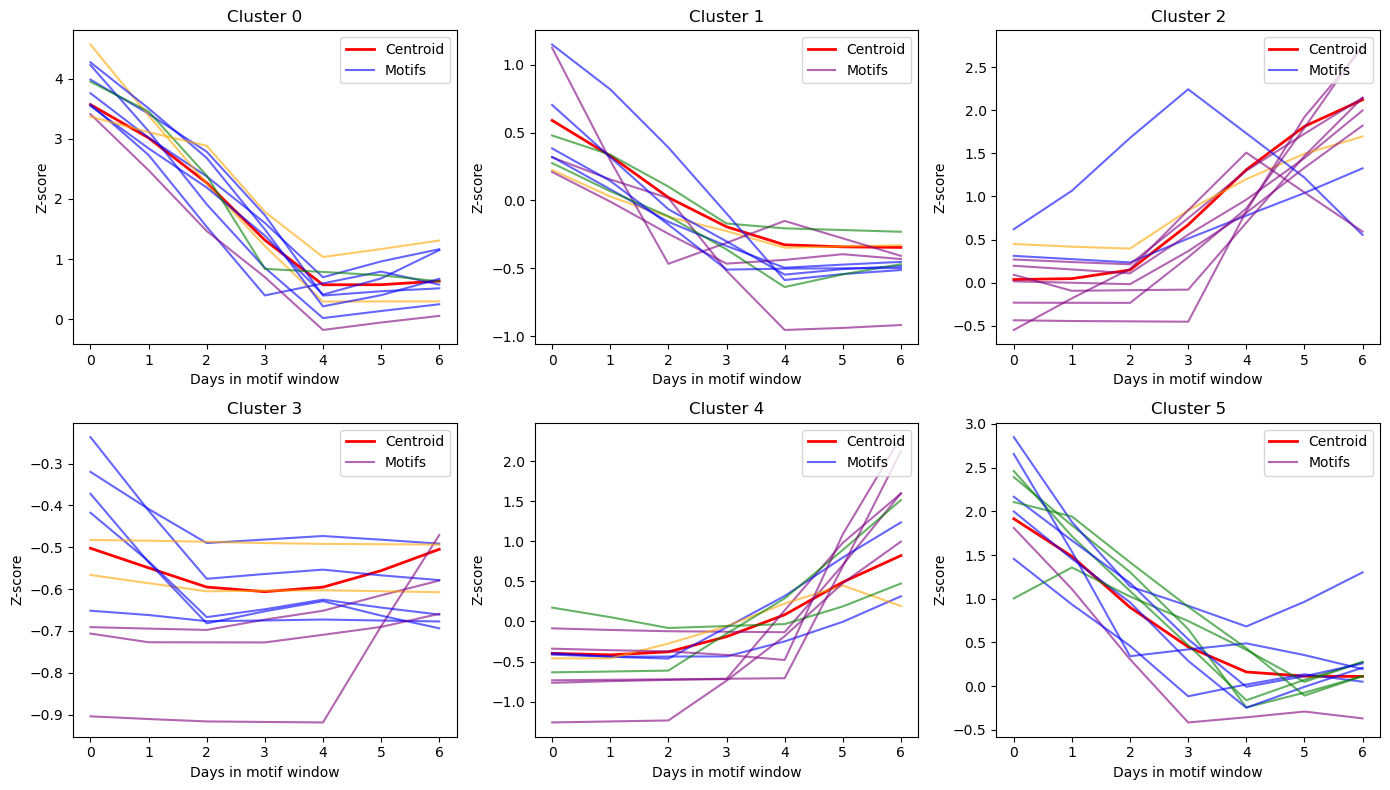

In [13]:
import seaborn as sns

# Definiamo una palette per le rating_category
rating_colors = {
    'Low': 'gray',
    'Medium Low': 'orange',
    'Medium': 'blue',
    'Medium High': 'green',
    'High': 'purple'
}

plt.figure(figsize=(14, 8))

for i in range(n_clusters):
    plt.subplot(2, 3, i+1)  # 2 righe x 3 colonne, adatta se n_clusters = 6
    
    # Centroid
    plt.plot(kmeans.cluster_centers_[i].ravel(), label='Centroid', color='red', linewidth=2)
    
    # Seleziona alcuni motifs del cluster i
    cluster_motifs = motif_df[motif_df['cluster'] == i]
    n_examples = min(10, len(cluster_motifs))  # massimo 5 per chiarezza
    sample_motifs = cluster_motifs.sample(n_examples, random_state=42)
    
    # Plot dei motifs colorati per rating_category
    for _, row in sample_motifs.iterrows():
        plt.plot(row['motif'], color=rating_colors[row['rating_category']], alpha=0.6)
    
    plt.title(f'Cluster {i}')
    plt.xlabel('Days in motif window')
    plt.ylabel('Z-score')
    plt.legend(['Centroid', 'Motifs'], loc='upper right')

plt.tight_layout()
plt.show()


In [14]:
for i, centroid in enumerate(kmeans.cluster_centers_):
    print(f"Cluster {i}: mean={centroid.mean():.2f}, std={centroid.std():.2f}, max={centroid.max():.2f}, min={centroid.min():.2f}")


Cluster 0: mean=1.71, std=1.16, max=3.57, min=0.57
Cluster 1: mean=-0.04, std=0.34, max=0.59, min=-0.35
Cluster 2: mean=0.88, std=0.81, max=2.12, min=0.04
Cluster 3: mean=-0.56, std=0.04, max=-0.50, min=-0.61
Cluster 4: mean=0.00, std=0.45, max=0.82, min=-0.42
Cluster 5: mean=0.73, std=0.67, max=1.92, min=0.11


In [15]:
window_split = 3  # primi 3 giorni vs ultimi 3
for i, centroid in enumerate(kmeans.cluster_centers_):
    early_mean = centroid[:window_split].mean()
    late_mean = centroid[-window_split:].mean()
    print(f"Cluster {i}: early_mean={early_mean:.2f}, late_mean={late_mean:.2f}")


Cluster 0: early_mean=2.95, late_mean=0.59
Cluster 1: early_mean=0.31, late_mean=-0.34
Cluster 2: early_mean=0.08, late_mean=1.75
Cluster 3: early_mean=-0.55, late_mean=-0.55
Cluster 4: early_mean=-0.40, late_mean=0.47
Cluster 5: early_mean=1.43, late_mean=0.13


In [16]:
from tslearn.metrics import dtw
import pandas as pd
import numpy as np

cluster_profiles = []

for i in range(n_clusters):
    # Estrai motifs del cluster i
    cluster_motifs = np.array([m for j, m in enumerate(motifs) if labels[j]==i])
    cluster_ratings = [motif_df.iloc[j]['rating_category'] for j, m in enumerate(motifs) if labels[j]==i]
    
    # Statistiche centroidi
    centroid = kmeans.cluster_centers_[i].ravel()
    mean_val = centroid.mean()
    std_val = centroid.std()
    max_val = centroid.max()
    min_val = centroid.min()
    
    # Pendenza media del centroide
    slope = np.diff(centroid).mean()
    
    # Variabilità interna
    dtw_dists = [dtw(m, centroid) for m in cluster_motifs]
    mean_dtw = np.mean(dtw_dists)
    
    # Distribuzione rating_category
    rating_counts = pd.Series(cluster_ratings).value_counts(normalize=True).to_dict()
    
    cluster_profiles.append({
        'cluster': i,
        'mean': mean_val,
        'std': std_val,
        'max': max_val,
        'min': min_val,
        'mean_slope': slope,
        'mean_dtw_to_centroid': mean_dtw,
        'rating_distribution': rating_counts
    })

# Creiamo un DataFrame riassuntivo
cluster_profiles_df = pd.DataFrame(cluster_profiles)
print(cluster_profiles_df)


   cluster      mean       std       max       min  mean_slope  \
0        0  1.706241  1.156787  3.568370  0.571852   -0.489178   
1        1 -0.038180  0.343304  0.589054 -0.345473   -0.155754   
2        2  0.878326  0.809098  2.121930  0.036601    0.347555   
3        3 -0.558544  0.039810 -0.502451 -0.606263   -0.000426   
4        4  0.001957  0.452622  0.821641 -0.416307    0.203226   
5        5  0.733989  0.672735  1.915551  0.110938   -0.300769   

   mean_dtw_to_centroid                                rating_distribution  
0              0.977244  {'Medium': 0.32113821138211385, 'High': 0.2967...  
1              0.550568  {'Medium': 0.359375, 'High': 0.3140625, 'Mediu...  
2              1.104087  {'High': 0.39520958083832336, 'Medium': 0.3473...  
3              0.488179  {'Medium': 0.34549071618037136, 'High': 0.3229...  
4              0.750103  {'High': 0.4156769596199525, 'Medium': 0.26128...  
5              0.818399  {'Medium': 0.3880952380952381, 'High': 0.30714... 

In [17]:
unique, counts = np.unique(labels, return_counts=True)
cluster_counts = dict(zip(unique, counts))
print(cluster_counts)

{0: 246, 1: 640, 2: 167, 3: 1508, 4: 421, 5: 420}
